# 📽 Movies Just Right For You

<br>

- Dataset: [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/)

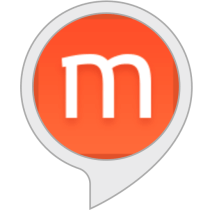

In [192]:
# import some libraries
import os
import time
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Data Load

In [181]:
# rating data load
rating_file_path = os.getenv('HOME') + '/aiffel/aiffel_projects/exploration/E9_recommendation_system/data/ml-1m/ratings.dat'

ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding='ISO-8859-1')

original_data_size = len(ratings)
original_data_size

1000209

In [182]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [183]:
# movie data load
movie_file_path=os.getenv('HOME') + '/aiffel/aiffel_projects/exploration/E9_recommendation_system/data/ml-1m/movies.dat'

cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')

movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


## Data Exploration & Preprocessing

In [185]:
ratings.shape

(1000209, 4)

In [202]:
rating_count = ratings.groupby('rating')['user_id'].count()
type(rating_count)

pandas.core.series.Series

In [ ]:
sns.histplot(data=(ratings['rating'].unique(), rating_count))

plt.show()

In [127]:
# 3점 이상만 남깁니다.
# 3점 미만은 선호하지 않는다고 판단
ratings = ratings[ratings['rating'] >= 3]
filtered_data_size = len(ratings)

print(f'original_data_size: {original_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / original_data_size:.2%}')

original_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [103]:
# rating 컬럼의 이름을 count로 바꿉니다.
# ratings.rename(columns={'rating':'count'}, inplace=True)

In [129]:
movies_dict = movies.copy()
movies_dict = movies_dict.set_index('title').T.to_dict('list')

movies_dict

{'Toy Story (1995)': [1, "Animation|Children's|Comedy"],
 'Jumanji (1995)': [2, "Adventure|Children's|Fantasy"],
 'Grumpier Old Men (1995)': [3, 'Comedy|Romance'],
 'Waiting to Exhale (1995)': [4, 'Comedy|Drama'],
 'Father of the Bride Part II (1995)': [5, 'Comedy'],
 'Heat (1995)': [6, 'Action|Crime|Thriller'],
 'Sabrina (1995)': [7, 'Comedy|Romance'],
 'Tom and Huck (1995)': [8, "Adventure|Children's"],
 'Sudden Death (1995)': [9, 'Action'],
 'GoldenEye (1995)': [10, 'Action|Adventure|Thriller'],
 'American President, The (1995)': [11, 'Comedy|Drama|Romance'],
 'Dracula: Dead and Loving It (1995)': [12, 'Comedy|Horror'],
 'Balto (1995)': [13, "Animation|Children's"],
 'Nixon (1995)': [14, 'Drama'],
 'Cutthroat Island (1995)': [15, 'Action|Adventure|Romance'],
 'Casino (1995)': [16, 'Drama|Thriller'],
 'Sense and Sensibility (1995)': [17, 'Drama|Romance'],
 'Four Rooms (1995)': [18, 'Thriller'],
 'Ace Ventura: When Nature Calls (1995)': [19, 'Comedy'],
 'Money Train (1995)': [20, 'Act

In [130]:
movies_idx_dict = movies.copy().set_index('movie_id').T.to_dict('list')

movies_idx_dict

{1: ['Toy Story (1995)', "Animation|Children's|Comedy"],
 2: ['Jumanji (1995)', "Adventure|Children's|Fantasy"],
 3: ['Grumpier Old Men (1995)', 'Comedy|Romance'],
 4: ['Waiting to Exhale (1995)', 'Comedy|Drama'],
 5: ['Father of the Bride Part II (1995)', 'Comedy'],
 6: ['Heat (1995)', 'Action|Crime|Thriller'],
 7: ['Sabrina (1995)', 'Comedy|Romance'],
 8: ['Tom and Huck (1995)', "Adventure|Children's"],
 9: ['Sudden Death (1995)', 'Action'],
 10: ['GoldenEye (1995)', 'Action|Adventure|Thriller'],
 11: ['American President, The (1995)', 'Comedy|Drama|Romance'],
 12: ['Dracula: Dead and Loving It (1995)', 'Comedy|Horror'],
 13: ['Balto (1995)', "Animation|Children's"],
 14: ['Nixon (1995)', 'Drama'],
 15: ['Cutthroat Island (1995)', 'Action|Adventure|Romance'],
 16: ['Casino (1995)', 'Drama|Thriller'],
 17: ['Sense and Sensibility (1995)', 'Drama|Romance'],
 18: ['Four Rooms (1995)', 'Thriller'],
 19: ['Ace Ventura: When Nature Calls (1995)', 'Comedy'],
 20: ['Money Train (1995)', 'Act

In [131]:
ratings.isna().sum()

user_id      0
movie_id     0
rating       0
timestamp    0
dtype: int64

In [132]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [133]:
ratings.shape

(836478, 4)

In [134]:
movies.shape

(3883, 3)

In [135]:
total = pd.merge(ratings, movies, how='inner', on='movie_id')
total.shape

(836478, 6)

In [136]:
total.isna().sum()

user_id      0
movie_id     0
rating       0
timestamp    0
title        0
genre        0
dtype: int64

In [137]:
total.sort_values(by=['user_id', 'movie_id'], axis=0, inplace=True)

In [138]:
total.head()

,user_id,movie_id,rating,timestamp,title,genre
38620,1,1,5,978824268,Toy Story (1995),Animation|Children's|Comedy
26760,1,48,5,978824351,Pocahontas (1995),Animation|Children's|Musical|Romance
37407,1,150,5,978301777,Apollo 13 (1995),Drama
43536,1,260,4,978300760,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
24237,1,527,5,978824195,Schindler's List (1993),Drama|War


In [139]:
# user들이 가장 많이 본 영화 TOP 30
movie_count = total.groupby('title')['user_id'].count()

movie_count.sort_values(ascending=False).head(30)

title
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2434
Jurassic Park (1993)                                     2413
Sixth Sense, The (1999)                                  2385
Fargo (1996)                                             2371
Braveheart (1995)                                        2314
Men in Black (1997)                                      2297
Schindler's List (1993)                                  2257
Pr

In [141]:
# 총 평점이 가장 높은 영화 TOP 30
movie_sum = total.groupby('title')['rating'].sum()

movie_sum.sort_values(ascending=False).head(30)

title
American Beauty (1999)                                   14449
Star Wars: Episode IV - A New Hope (1977)                13178
Star Wars: Episode V - The Empire Strikes Back (1980)    12648
Saving Private Ryan (1998)                               11348
Star Wars: Episode VI - Return of the Jedi (1983)        11303
Raiders of the Lost Ark (1981)                           11179
Silence of the Lambs, The (1991)                         11096
Matrix, The (1999)                                       10903
Sixth Sense, The (1999)                                  10703
Terminator 2: Judgment Day (1991)                        10513
Fargo (1996)                                             10465
Schindler's List (1993)                                  10317
Braveheart (1995)                                        10125
Shawshank Redemption, The (1994)                         10085
Back to the Future (1985)                                10081
Godfather, The (1972)                            

In [142]:
total.tail()

,user_id,movie_id,rating,timestamp,title,genre
656608,6040,3683,4,960971696,Blood Simple (1984),Drama|Film-Noir
531073,6040,3703,4,964828575,Mad Max 2 (a.k.a. The Road Warrior) (1981),Action|Sci-Fi
128146,6040,3735,4,960971654,Serpico (1973),Crime|Drama
342081,6040,3751,4,964828782,Chicken Run (2000),Animation|Children's|Comedy
796104,6040,3819,5,963272166,Tampopo (1986),Comedy


In [143]:
last_idx = total['user_id'].unique()[-1]

last_idx

6040

In [144]:
my_favorite = ['Men in Black (1997)', "Schindler's List (1993)", "Titanic (1997)", "Before Sunrise (1995)", "Nightmare Before Christmas, The (1993)"]
my_idx = [movies_dict[m][0] for m in my_favorite]
my_genre = [movies_dict[m][1] for m in my_favorite]

print(my_idx)
print(my_genre)

[1580, 527, 1721, 215, 551]
['Action|Adventure|Comedy|Sci-Fi', 'Drama|War', 'Drama|Romance', 'Drama|Romance', "Children's|Comedy|Musical"]


In [145]:
timestamp = time.time()

In [146]:
my_playlist = pd.DataFrame({'user_id': [last_idx+1]*5, 'movie_id': my_idx, 'rating': [5]*5, 'timestamp': timestamp, 'title': my_favorite, 'genre': my_genre})

# last_idx == 6040이면 추가
if not total.isin({'user_id': [6041]})['user_id'].any():
    total = total.append(my_playlist)

In [147]:
total.tail(10)

,user_id,movie_id,rating,timestamp,title,genre
656608,6040,3683,4,9.609717e+08,Blood Simple (1984),Drama|Film-Noir
531073,6040,3703,4,9.648286e+08,Mad Max 2 (a.k.a. The Road Warrior) (1981),Action|Sci-Fi
128146,6040,3735,4,9.609717e+08,Serpico (1973),Crime|Drama
342081,6040,3751,4,9.648288e+08,Chicken Run (2000),Animation|Children's|Comedy
796104,6040,3819,5,9.632722e+08,Tampopo (1986),Comedy
0,6041,1580,5,1.629372e+09,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi
1,6041,527,5,1.629372e+09,Schindler's List (1993),Drama|War
2,6041,1721,5,1.629372e+09,Titanic (1997),Drama|Romance
3,6041,215,5,1.629372e+09,Before Sunrise (1995),Drama|Romance
4,6041,551,5,1.629372e+09,"Nightmare Before Christmas, The (1993)",Children's|Comedy|Musical


In [148]:
final = total.drop(['timestamp', 'title', 'genre'], axis=1)

final.head(10)

,user_id,movie_id,rating
38620,1,1,5
26760,1,48,5
37407,1,150,5
43536,1,260,4
24237,1,527,5
51347,1,531,4
32415,1,588,4
9764,1,594,4
12121,1,595,5
53172,1,608,4


In [164]:
final.reset_index(drop=True, inplace=True)

In [170]:
final.shape

(836483, 3)

In [171]:
final['user_id'].nunique()

6040

In [152]:
final['movie_id'].nunique()

3628

In [167]:
final.rating

0         5
1         5
2         5
3         4
4         5
         ..
836478    5
836479    5
836480    5
836481    5
836482    5
Name: rating, Length: 836483, dtype: int64

In [ ]:
num_user = final['user_id'].nunique()
num_movie = final['movie_id'].nunique()

csr_data = csr_matrix((final.rating, (final.user_id, final.movie_id)), shape=(num_user, num_movie))